## Library Preparation

In [1]:
!pip install pytorch_lightning -qq
!pip install --upgrade wandb -qq
!pip install kaggle
!pip install torchmetrics

In [2]:
! mkdir ~/.kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download shifatearman/bananalsd

 97% 36.0M/36.9M [00:02<00:00, 23.5MB/s]
100% 36.9M/36.9M [00:02<00:00, 14.2MB/s]


In [ ]:
! unzip bananalsd.zip

## Data Preparation

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings("ignore")

### Import datasets

In [3]:
# Use ImageFolder to create dataset(s)
data_dir = "/content/BananaLSD/OriginalSet"
# data_dir = "BananaLSD/OriginalSet"

dataset = datasets.ImageFolder(root=data_dir)

dataset

Dataset ImageFolder
    Number of datapoints: 937
    Root location: /content/BananaLSD/OriginalSet

In [4]:
# Get class names as a list
class_names = dataset.classes
class_names

['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']

In [5]:
# Can also get class names as a dict
class_dict = dataset.class_to_idx
class_dict

{'cordana': 0, 'healthy': 1, 'pestalotiopsis': 2, 'sigatoka': 3}

### Splitting datasets

In [6]:
# Splitting ratio
train_ratio = 0.8 * 0.8
val_ratio = 0.8 * 0.2
test_ratio = 0.2

# Hitung ukuran dataset untuk setiap bagian
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Bagi dataset menjadi bagian training, validasi, dan testing
seed = torch.Generator().manual_seed(42)
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=seed)

In [7]:
# Check the lengths
len(train_data), len(val_data), len(test_data)

(599, 149, 189)

### Apply data transformation on splitted data

In [8]:
class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = ApplyTransform(train_data, transform=train_transforms)
val_data = ApplyTransform(val_data, transform=test_transforms)
test_data = ApplyTransform(test_data, transform=test_transforms)

In [10]:
train_data.transform, val_data.transform, test_data.transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ))

### Apply data augmentation and convert it to dataloader

In [11]:
import os

# see how much cpu core -> for dataloader worker
os.cpu_count()

2

In [12]:
batch_size = 64

# train split dataloader
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          num_workers=2,
                          shuffle=True
                          )

# valid split dataoader
val_loader = DataLoader(val_data,
                        num_workers=2,
                        batch_size=batch_size
                        )

# test split dataloader
test_loader = DataLoader(test_data,
                         num_workers=2,
                         batch_size=batch_size
                         )

### Visualize some data

Image shape: torch.Size([64, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])



Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


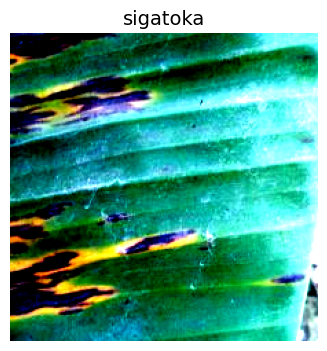

In [13]:
import matplotlib.pyplot as plt

img, label = next(iter(train_loader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
print()

for id, (X, y) in enumerate(train_loader):
    # Rearrange the order of dimensions
    img_permute = X[0].permute(1, 2, 0)

    # Print out different shapes (before and after permute)
    print(f"Original shape: {X[0].shape} -> [color_channels, height, width]")
    print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

    # Plot the image
    plt.figure(figsize=(8, 4))
    plt.imshow(img_permute)
    plt.axis("off")
    plt.title(class_names[y[0]], fontsize=14);
    break

## Modelling

In [14]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchmetrics.functional import accuracy
import pytorch_lightning as pl

print(torch.cuda.is_available())

True


In [15]:
import wandb
wandb.login()

wandb: Currently logged in as: hiseulgi. Use `wandb login --relogin` to force relogin


True

### TinyVGG Lightning Model

In [16]:
INPUT_SHAPE = 3
# HIDDEN_UNITS = 16
HIDDEN_UNITS = [10, 10, 10, 10]
# HIDDEN_UNITS = [16, 32, 64, 32]
# HIDDEN_UNITS = [16, 32, 32, 16]
# HIDDEN_UNITS = [32, 64, 32, 16]
DROPOUT_RATE = 0.0
OUTPUT_SHAPE = 4

pl.seed_everything(42)

class LitTinyVGG(pl.LightningModule):
    def __init__(self, hidden_units, dropout_rate, lr=1e-3):
        super().__init__()

        # conv layer block 1
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels = INPUT_SHAPE,
                out_channels = hidden_units[0],
                kernel_size = 3,
                padding = 1
            ),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Conv2d(
                in_channels = hidden_units[0],
                out_channels = hidden_units[1],
                kernel_size = 3,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # conv layer block 2
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels = hidden_units[1],
                out_channels = hidden_units[2],
                kernel_size = 3,
                padding = 1
            ),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Conv2d(
                in_channels = hidden_units[2],
                out_channels = hidden_units[3],
                kernel_size = 3,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # classifier layer block
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(
                in_features = hidden_units[3] * 56 * 56,
                out_features = OUTPUT_SHAPE
            )
        )

        # loss
        self.loss = nn.CrossEntropyLoss()

        # learning rate for optimizer
        self.lr = lr

        # save hyper-parameters to self.hparams (auto-logged by W&B)
        self.save_hyperparameters()

    def forward(self, x: torch.Tensor):
        '''method used for inference input -> output'''

        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'train_loss': loss, 'train_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'val_loss': loss, 'val_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        # Let's return preds to use it in a custom callback
        return preds

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        logs = {'test_loss': loss, 'test_accuracy': acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

    def configure_optimizers(self):
        '''defines model optimizer'''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds, y, "multiclass", num_classes=OUTPUT_SHAPE)
        return preds, loss, acc

INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [29]:
# model_0 = LitTinyVGG(HIDDEN_UNITS, DROPOUT_RATE)
# model_0

### Wandb Setting & Callback

In [17]:
from pytorch_lightning.callbacks import Callback

class LogPredictionsCallback(Callback):

    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx = 0):
        """Called when the validation batch ends."""

        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case

        # Let's log 20 sample image predictions from first batch
        if batch_idx == 0:
            n = 20
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' for y_i, y_pred in zip(y[:n], outputs[:n])]

            # Option 1: log images with `WandbLogger.log_image`
            trainer.logger.log_image(key='sample_images', images=images, caption=captions)

            # Option 2: log predictions as a Table
            columns = ['image', 'ground truth', 'prediction']
            data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
            trainer.logger.log_table(key='sample_table', columns=columns, data=data)

In [31]:
# from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Checkpoint
# checkpoint_callback = ModelCheckpoint(monitor='val_loss',
#                                       save_top_k=1,
#                                       save_last=True,
#                                       save_weights_only=True,
#                                       filename='checkpoint/{epoch:02d}-{val_loss:.4f}',
#                                       verbose=False,
#                                       mode='min')
# checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

# Earlystopping
# earlystopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')



In [32]:
# from pytorch_lightning.loggers import WandbLogger

# wandb_logger = WandbLogger(project="banana-leaf-diseases", # group runs in "MNIST" project
#                            tags=["tiny-vgg"],
#                            log_model="all") # log all new checkpoints during training

### Train the model with Trainer

In [33]:
# from pytorch_lightning import Trainer

# trainer = Trainer(
#     logger=wandb_logger,                    # W&B integration
#     callbacks=[checkpoint_callback,
#                log_predictions_callback,
#                earlystopping],
#     accelerator="gpu",                      # use GPU
#     max_epochs=50)                           # number of epochs

In [34]:
# trainer.fit(model_0, train_loader, val_loader)
# wandb.finish()

In [19]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


INPUT_SHAPE = 3
HIDDEN_UNITS_LIST = [[10, 10, 10, 10],
                     [16, 32, 64, 32],
                     [16, 32, 32, 16],
                     [32, 64, 32, 16]]
DROPOUT_RATE = 0.2
OUTPUT_SHAPE = 4

# Inisialisasi Weights & Biases
# wandb.init()

# Loop melalui setiap konfigurasi HIDDEN_UNITS
for i, hidden_units in enumerate(HIDDEN_UNITS_LIST):
    pl.seed_everything(42)

    model_temp = LitTinyVGG(hidden_units, DROPOUT_RATE)

    wandb_logger = WandbLogger(project="banana-leaf-diseases",
                               tags=["tiny-vgg"],
                               name="tiny-vgg-with-dropout-" + str(i),
                               log_model="all")

    log_predictions_callback = LogPredictionsCallback()
    early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min")

    trainer = Trainer(
        logger=wandb_logger,
        callbacks=[
               log_predictions_callback,
               early_stopping_callback
               ],
        accelerator="gpu",
        max_epochs=50)

    trainer.fit(model_temp, train_loader, val_loader)

    # Log akhir eksperimen
    wandb.log({"final_train_loss": trainer.callback_metrics["train_loss"],
               "final_val_loss": trainer.callback_metrics["val_loss"]})

    wandb.finish()

INFO:lightning_fabric.utilities.seed:Global seed set to 42


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | conv_block_1 | Sequential       | 1.2 K 
1 | conv_block_2 | Sequential       | 1.8 K 
2 | classifier   | Sequential       | 125 K 
3 | loss         | CrossEntropyLoss | 0     
--------------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.514     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▂▃▃▃▃▃▄▄▄▅▅▄▅▅▆▆▅▅▆▆▆▇▇▇▇▇▇▇▇▇█████████
train_loss,█▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▂▂▂▃▃▃▃▃▄▄▅▄▅▅▆▆▅▆▅▆▅▆▇▆▆▇██▇█▇▇▇█▇▇▇▆▇
val_loss,█▆▅▆▅▅▅▄▄▄▄▅▃▃▃▃▃▄▃▃▃▄▂▂▂▂▂▁▁▂▁▁▂▁▁▂▂▁▃▁
epoch,39
final_train_loss,0.51856
final_val_loss,0.63705


INFO:lightning_fabric.utilities.seed:Global seed set to 42


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | conv_block_1 | Sequential       | 5.1 K 
1 | conv_block_2 | Sequential       | 37.0 K
2 | classifier   | Sequential       | 401 K 
3 | loss         | CrossEntropyLoss | 0     
--------------------------------------------------
443 K     Trainable params
0         Non-trainable params
443 K     Total params
1.774     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇
train_loss,█▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_accuracy,▁▂▂▂▃▃▃▃▃▄▆▇▅▆▇▄▆▆▅███▇▆▆▇▇▇█▇▇
val_loss,█▇▆▆▆▆▅▆▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▃▂
epoch,30
final_train_loss,0.58807
final_val_loss,0.66013


INFO:lightning_fabric.utilities.seed:Global seed set to 42


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | conv_block_1 | Sequential       | 5.1 K 
1 | conv_block_2 | Sequential       | 13.9 K
2 | classifier   | Sequential       | 200 K 
3 | loss         | CrossEntropyLoss | 0     
--------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.879     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▃▂▃▄▄▅▅▆▆▆▆▇▆▆▆▇▇▇█▇▇▇██
train_loss,█▆▆▅▅▅▄▄▄▄▂▃▂▃▂▂▂▂▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▂▁▃▃▅▃▆▄▅▇▅▇▅▇▆▇▇█▇▇█▇▇▇▆
val_loss,█▇▇▆▅▆▄▅▃▄▂▃▄▃▃▂▂▂▂▁▁▂▁▂▁
epoch,24
final_train_loss,0.54805
final_val_loss,0.68746


INFO:lightning_fabric.utilities.seed:Global seed set to 42


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | conv_block_1 | Sequential       | 19.4 K
1 | conv_block_2 | Sequential       | 23.1 K
2 | classifier   | Sequential       | 200 K 
3 | loss         | CrossEntropyLoss | 0     
--------------------------------------------------
243 K     Trainable params
0         Non-trainable params
243 K     Total params
0.973     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_train_loss,▁
final_val_loss,▁
train_accuracy,▁▃▃▄▄▃▄▅▅▅▆▆▆▆▆▇▇▆█▇█
train_loss,█▆▅▅▄▅▄▃▄▃▃▃▂▂▂▁▁▂▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▁▂▄▃▂▃▄▅▅▅▅▅▆▇▆▇▇▆█▇
val_loss,██▇▇▆▆▄▄▄▅▃▄▃▃▁▁▂▁▁▁▂
epoch,20
final_train_loss,0.67262
final_val_loss,0.76517
